In [71]:
#Importem tot el necessari:
from pylab import *
from scipy.optimize import curve_fit
%matplotlib inline

## Input parameters:

In [72]:
#BACTERIA:
N = 1
v0 = 3 #um/s
lam = 1 #s^-1
Rb=0.5 #um

#BOX (Square simulation box)
L = 20 #um 
#Discretisation for density computation
n=100
dx = L/n #um 

#viscosity (of water)
eta=0.001 #Pa*s

# Time step in seconds
dt = 0.1 #s

#Passive particle
R=5. #um

#drag coefficients:
gamma_sphere=6*pi*eta*R
gamma_cell=6*pi*eta*Rb
ratio_gamma=gamma_cell/gamma_sphere



## Classes and methods

In [73]:
class Bacteria:

    def __init__(self, N, v0, lam):
        self.N = N
        self.v0 = v0
        self.lam = lam
        self.pos = zeros((2,N))
        self.theta = random(N)*2*pi
        self.dir = array([cos(self.theta), sin(self.theta)])
        self.v = v0

    def distribute(self, L):
        self.pos = random((2,N))*L
        
    def evolve(self, dt, cells_v):
        #self.v=vprofile(self.pos)
        self.pos += dt*cells_v*self.dir
        self.tumble(dt)
        self.boundary(L)
        
        
    def tumble(self, dt):
        r = random(self.N)
        cond = r<self.lam*dt
        ntumbles = count_nonzero(cond)
        theta = random(ntumbles)*2*pi
        self.theta[cond] = theta
        self.dir[:,cond] = array([cos(theta), sin(theta)])
        
    # PBC    
    def boundary(self, L):
        self.pos[self.pos>L]-=L
        self.pos[self.pos<0]+=L

class Passive:

    def __init__(self, R):
        self.R = R
        self.pos = zeros((2,1))
        self.dir = zeros((2,1))
        self.v=0.

    def distribute(self, L):
        self.pos = random((2,1))*L
        
        
    def evolve(self, dt, sphere_v, sphere_dir):       
        self.pos += dt*sphere_v*sphere_dir
        self.boundary(L)

    # PBC    
    def boundary(self, L):
        self.pos[self.pos>L]-=L
        self.pos[self.pos<0]+=L
        

        
def vprofile(pos):
    v=v0
    #+pos[0]*0.05
    return(v)          


def interaction(cells,sphere):
    # distance:
    drx=cells.pos[0]-sphere.pos[0]
    dry=cells.pos[1]-sphere.pos[1]
    dr=sqrt(drx*drx+dry*dry)
    
    # is the cell TOUCHING the sphere?
    dR=dt*cells.v
    cutoff=R+Rb+dR
    contact=zeros(N,dtype=bool)
    contact[(dr<cutoff)*(R<dr)]=True
    
    # is the cell PUSHING the sphere?
    push=zeros(N,dtype=bool)
    #vector that goes from the cell to the sphere:
    v_cs=subtract(sphere.pos,cells.pos)
    scalarproduct=dot(v_cs.T,cells.dir)[0]
    push[scalarproduct>0]=True
        

    sphere_v=zeros((2,1))
    sphere_dir=zeros((2,1))
    
    cells_v=ones((2,1))*cells.v


    # if they are touching and the cell is pushing the sphere...
    new_v=cells.v*ratio_gamma
    sphere_v[:,contact*push]=new_v
    cells_v[:,contact*push]=new_v

    sphere_dir[:,contact*push]=cells.dir
    
    
    return sphere_v,sphere_dir,cells_v


class density:
    def __init__(self, cells, n, dx):
        self.n = n
        self.dx=dx
        self.counts=zeros((self.n,self.n))    

    def snapshot(self,pos):      
        self.counts,bin_edges,bars=histogram2d(cells.pos[0], cells.pos[1], bins=(n,n))




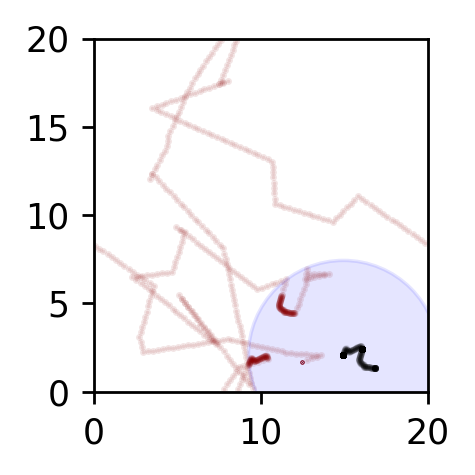

In [82]:
cells = Bacteria(1, v0, lam)
cells.distribute(L)

sphere = Passive(R)
sphere.distribute(L)


#-------------------------------------------------------------------------------
# plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(2,2),dpi=250)
mysize=6
xlim(right=L,left=0)
ylim(top=L,bottom=0)
#-------------------------------------------------------------------------------
scatter(cells.pos[0],cells.pos[1],s=0.1,color='darkred',alpha=1)
scatter(sphere.pos[0],sphere.pos[1],s=3000,color='blue',alpha=0.1)

steps = 500


results_c=zeros((steps,2))
results_s=zeros((steps,2))



for i in range(steps):
        
    sphere_v,sphere_dir,cells_v=interaction(cells,sphere)
    #cells_v=1.
    cells.evolve(dt,cells_v)
    sphere.evolve(dt,sphere_v,sphere_dir)
    
    scatter(sphere.pos[0],sphere.pos[1],s=1,color='black',alpha=0.1)
    scatter(cells.pos[0],cells.pos[1],s=1,color='darkred',alpha=0.1)
    
    # we save the results to animate later
    results_c[i,0]=cells.pos[0]
    results_c[i,1]=cells.pos[1]
    results_s[i,0]=sphere.pos[0]
    results_s[i,1]=sphere.pos[1]
    

fig.tight_layout()

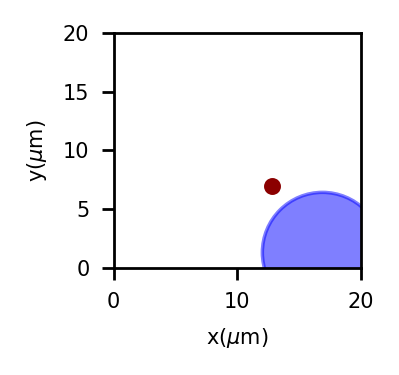

In [83]:
from matplotlib import animation
from IPython.display import HTML

fr_ps=np.int(1./dt)

# Speed up the video:
speed=1. 

fig = plt.figure(figsize=(1.7,1.6),dpi=250)
ax = plt.axes(xlim=(0, L), ylim=(0, L)) 
scat = ax.scatter([], [], s=15, color='darkred')
scats = ax.scatter([], [], s=1200, color='blue',alpha=0.5) 

line, = ax.plot([], [], lw=2) 

#plt.title( 'Particles with $v_0$=' + str(v0) + ' $\mu$m/s, a probability of tumbling \n'
#            '$P_t=$' + str(p_s) + ' $s^{-1}$ (video speed ' + str(speed) + 'x)', fontsize=mysize)            
plt.xlabel('x($\mu$m)',fontsize=mysize)
plt.ylabel('y($\mu$m)',fontsize=mysize)
ax.tick_params(labelsize=mysize)
plt.tight_layout()


def init(): 
    # creating an empty plot/frame 
    line.set_data([], []) 
    return line, 


# animation function 
def animate(i): 
    scat.set_offsets(results_c[i,:])
    scats.set_offsets(results_s[i,:])

    return scat, scats
    
anim = animation.FuncAnimation(fig, animate, init_func=init, 
                        frames=steps, interval=100/speed, blit=True) 

HTML(anim.to_html5_video())

In [84]:
anim.save('testcollision_drag_v2.mp4', writer = 'ffmpeg')#, fps = speed*fr_ps) 